# Getting started with Xarray

Useful links:
* Xarray: http://xarray.pydata.org/en/stable/
* Dask: http://dask.pydata.org/en/latest/

Install using conda:
http://xarray.pydata.org/en/stable/installing.html#instructions

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### Open dataset
Download some CMIP6 sample data from [here](http://esgdata.gfdl.noaa.gov/thredds/fileServer/gfdl_dataroot3/CMIP/NOAA-GFDL/GFDL-AM4/amip/r1i1p1f1/Amon/tas/gr1/v20180807/tas_Amon_GFDL-AM4_amip_r1i1p1f1_gr1_198001-201412.nc)

In [2]:
file = '~/.baspy/sample_data/tas_Amon_GFDL-AM4_amip_r1i1p1f1_gr1_198001-201412.nc'
ds   = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 420)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon        (lon) float64 0.625 1.875 3.125 4.375 5.625 6.875 8.125 9.375 ...
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 1980-02-15T12:00:00 ...
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
Attributes:
    title:                 NOAA GFDL GFDL-AM4 model output prepared for CMIP6...
    history:               File was processed by fremetar (GFDL analog of CMO...
    table_id:              Amon
    contact:               gfdl.climate.model.info@noaa.gov
    comment:               <null ref>
    tracking_id:           hdl:21.14100/3b95ceac-9bd6-42c9-a130-130fc1ba108c
    further_info_url:      https://furth

### Extract a DataArray/variable (tas = Near-Surface Air Temperature)

In [3]:
da= ds.tas
da

<xarray.DataArray 'tas' (time: 420, lat: 180, lon: 288)>
[21772800 values with dtype=float32]
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 0.625 1.875 3.125 4.375 5.625 6.875 8.125 9.375 ...
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 1980-02-15T12:00:00 ...
Attributes:
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    standard_name:  air_temperature
    interp_method:  conserve_order2
    original_name:  tas

### Plot a map for the first time instance

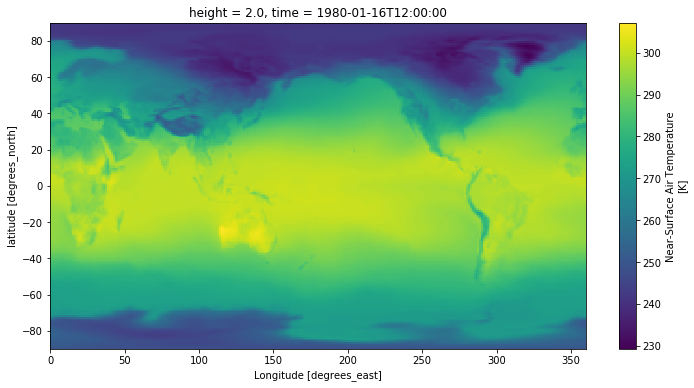

In [4]:
da.isel(time=0).plot(figsize=(12,6))

### Resampling data to a coarser grid

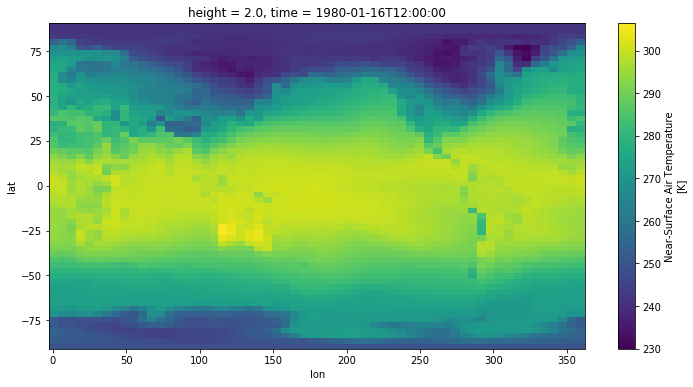

In [5]:
lons_new = np.linspace(da.lon.min(), da.lon.max(), 60)
lats_new = np.linspace(da.lat.min(), da.lat.max(), 60)
da.interp(coords={'lat':lats_new, 'lon':lons_new}, method='linear').isel(time=0).plot(figsize=(12,6))

### Extract a time series for a given point

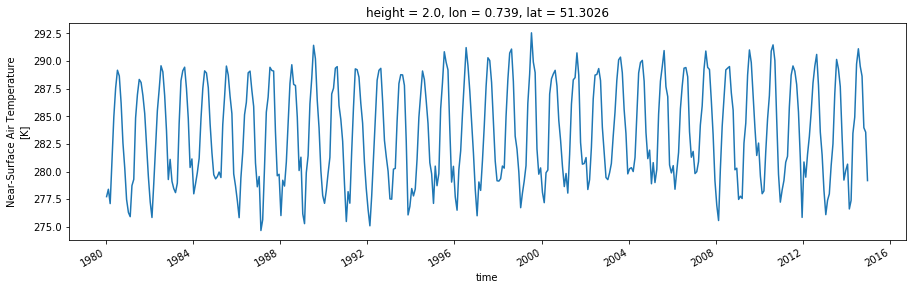

In [6]:
london = da.interp(coords={ 'lon':0.739, 'lat':51.3026 }, method='nearest')
london.plot(figsize=(15,4))

In [7]:
### save to csv
london_df = london.to_dataframe().reset_index()
london_df.to_csv('model_data_for_london.csv', index=False)

### Plotting using Cartopy

Text(0.5, 1.0, 'My title \n')

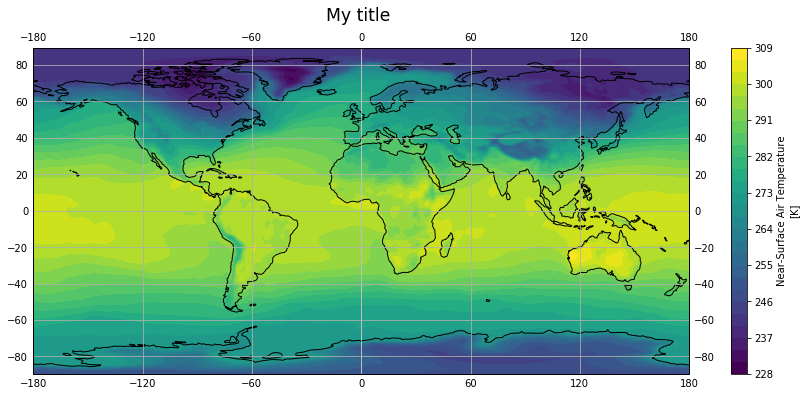

In [8]:
plt.figure(figsize=(15,6))
ax = plt.subplot(projection=ccrs.PlateCarree())
da.isel(time=0).plot.contourf('lon', 'lat', ax=ax, levels=30)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('My title \n', size='xx-large')

### Rolling longitudes for regional plotting over Greenwich meridian

In [9]:
da.lon.values[0:-1:20] # thinned out list

array([  0.625,  25.625,  50.625,  75.625, 100.625, 125.625, 150.625,
       175.625, 200.625, 225.625, 250.625, 275.625, 300.625, 325.625,
       350.625])

In [10]:
### converts lats '0 to 360' --> '-180 to 180' (To do: Wrap this up into a definition)
lon_ew = da.lon.values.copy()
lon_ew[ lon_ew > 180. ] = lon_ew[ lon_ew > 180. ] - 360.
lon_ew
da_rolled = da.assign_coords(lon=(lon_ew)).roll(lon=( len(lon_ew) // 2))

In [11]:
da_rolled.lon.values[0:-1:20] # thinned out list

array([-179.375, -154.375, -129.375, -104.375,  -79.375,  -54.375,
        -29.375,   -4.375,   20.625,   45.625,   70.625,   95.625,
        120.625,  145.625,  170.625])

In [12]:
da_uk = da_rolled.sel( lon=slice(-20,20), lat=slice(30,70) )

Text(0.5, 1.0, '')

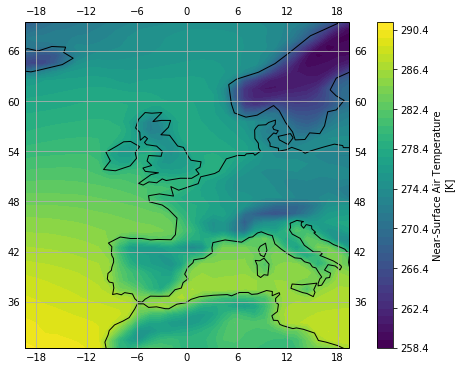

In [13]:
plt.figure(figsize=(10,6))
ax = plt.subplot(projection=ccrs.PlateCarree())
da_uk.isel(time=0).plot.contourf('lon', 'lat', ax=ax, levels=50)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('')